In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from ipywidgets import interact, IntSlider

import torch
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Setup

In [2]:
from read_results import read_varnames
import small_strato_f90.kpp4py as kpp

In [3]:
nvar = 5
varnames = read_varnames("small_strato_F90/small_strato_Parameters.f90")[0:nvar]
print(varnames)

['O1D', 'O', 'O3', 'NO', 'NO2']


In [4]:
df_range = (
    pd.read_csv('small_strato_range.csv', index_col=0)
    .append(pd.DataFrame(np.array([[0.0, 1.0]]), 
                         columns=['min','max'], 
                         index=['SUN']
                        )
           )
)

df_range['mid'] = 0.5*(df_range['min']+df_range['max'])
df_range['span'] = df_range['max'] - df_range['min']
df_range['span']['SUN'] = 0.0 # don't change SUN
df_range.tail(10)

,min,max,mid,span
O1D,1.000000e-08,1.550810e+02,7.754051e+01,1.550810e+02
O,1.000000e-08,1.040641e+09,5.203203e+08,1.040641e+09
O3,5.377002e+11,8.486620e+11,6.931811e+11,3.109618e+11
NO,1.000000e-08,9.433271e+08,4.716635e+08,9.433271e+08
NO2,1.531729e+08,1.096500e+09,6.248365e+08,9.433271e+08
SUN,0.000000e+00,1.000000e+00,5.000000e-01,0.000000e+00


# Investigate data range

## React one step

In [5]:
y0_list =  np.random.uniform(df_range['min'], 
                             df_range['max']+0.0*df_range['span'], 
                             size=(5000, nvar+1))
y0_list.shape

(5000, 6)

In [6]:
%time y1_list = kpp.onestep(y0_list.T).T
y1_list.shape

CPU times: user 111 ms, sys: 2.16 ms, total: 113 ms
Wall time: 127 ms


(5000, 5)

In [7]:
@interact(n=IntSlider(min=0,max=4,step=1,value=0,continuous_update=True))
def plot_dist(n):
    plt.hist(y0_list[:,n], bins=20, alpha=0.5, label='before')
    plt.hist(y1_list[:,n], bins=20, alpha=0.5, label='after')
    plt.legend()
    plt.title(varnames[n])

interactive(children=(IntSlider(value=0, description='n', max=4), Output()), _dom_classes=('widget-interact',)…

## React one more step, no visible change in distribution.

In [8]:
SUN_pert = np.random.permutation(y0_list[:,-1:]) 

In [9]:
%time y2_list = kpp.onestep(np.c_[y1_list, SUN_pert].T).T  # use the same SUN as y0
y2_list.shape

CPU times: user 95.6 ms, sys: 2.62 ms, total: 98.3 ms
Wall time: 102 ms


(5000, 5)

In [10]:
@interact(n=IntSlider(min=0,max=4,step=1,value=0,continuous_update=True))
def plot_dist(n):
    plt.hist(y1_list[:,n], bins=20, alpha=0.5, label='before')
    plt.hist(y2_list[:,n], bins=20, alpha=0.5, label='after')
    plt.legend()
    plt.title(varnames[n])

interactive(children=(IntSlider(value=0, description='n', max=4), Output()), _dom_classes=('widget-interact',)…

## Correlation plot

In [11]:
df_y1 = pd.DataFrame(y1_list, columns=varnames)
df_y1.head()

,O1D,O,O3,NO,NO2
0,63.375155,4.847964e+08,6.554911e+11,9.979908e+08,2.736366e+08
1,24.111161,2.285976e+08,5.982811e+11,2.655512e+08,1.139084e+08
2,1.974475,4.956387e+07,7.720027e+11,2.589086e+08,5.926957e+08
3,136.454730,9.234506e+08,7.705306e+11,8.538808e+08,1.774740e+08
4,51.638247,4.289113e+08,7.675859e+11,8.400524e+08,3.165048e+08


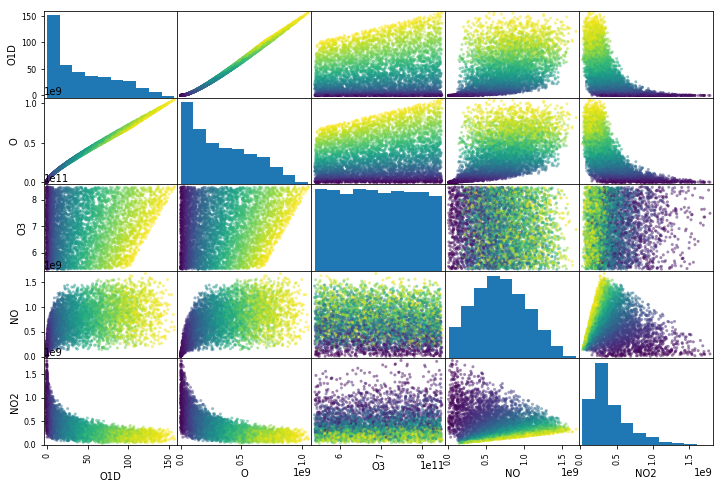

In [12]:
pd.plotting.scatter_matrix(df_y1, c=y0_list[:,-1:], figsize=(12, 8), alpha=0.5);

In [13]:
df_y1.corr()

,O1D,O,O3,NO,NO2
O1D,1.000000,0.995852,0.144355,0.519944,-0.632789
O,0.995852,1.000000,0.169525,0.547890,-0.663347
O3,0.144355,0.169525,1.000000,-0.064921,0.082342
NO,0.519944,0.547890,-0.064921,1.000000,-0.234246
NO2,-0.632789,-0.663347,0.082342,-0.234246,1.000000


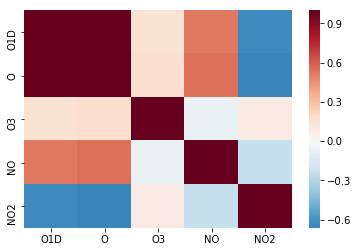

In [14]:
sns.heatmap(df_y1.corr(), cmap='RdBu_r', center=0.0)

In [15]:
df_y2 = pd.DataFrame(y2_list, columns=varnames)

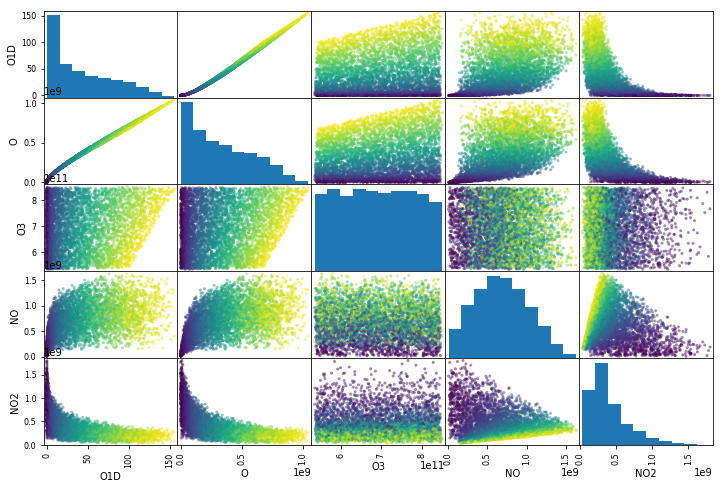

In [16]:
pd.plotting.scatter_matrix(df_y2, c=SUN_pert, figsize=(12, 8), alpha=0.5);